In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes, labels = [], []

    for obj in root.findall("object"):
        label = obj.find("name").text  # Get class label
        bbox = obj.find("bndbox")      # Get bounding box
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return boxes, labels


def load_dataset(folder_path):
    images, labels = [], []

    # Loop through the folder and match each image with its XML annotation
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            xml_path = os.path.join(folder_path, filename.replace(".jpg", ".xml"))

            if os.path.exists(xml_path):
                # Load the image and annotation
                img = cv2.imread(img_path)
                _, label_list = parse_xml(xml_path)

                # If multiple labels exist, duplicate the image entry
                for label in label_list:
                    images.append(img)
                    labels.append(label)
            else:
                print(f"Warning: XML annotation missing for {filename}")

    return images, labels

In [3]:
dataset_path = "/content/drive/MyDrive/7th Sem/DL/Object detection dataset/train/train"

images, all_labels = load_dataset(dataset_path)

assert len(images) == len(all_labels), "Mismatch between images and labels!"

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)

In [4]:
num_classes = len(np.unique(encoded_labels))
y = np.zeros((len(encoded_labels), num_classes))
for i, label in enumerate(encoded_labels):
    y[i, label] = 1

X = np.array([cv2.resize(img, (224, 224)) / 255.0 for img in images])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 372, Test samples: 93


# **Model train and test**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=2.0,
    height_shift_range=2.0 ,zoom_range=0.15, horizontal_flip=True)
datagen.fit(X_train)

# Example Model Definition (Using a Simple CNN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 754ms/step - accuracy: 0.3915 - loss: 6.2611 - val_accuracy: 0.6989 - val_loss: 0.8453
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.7656 - loss: 0.7075 - val_accuracy: 0.8065 - val_loss: 0.4863
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.8447 - loss: 0.3931 - val_accuracy: 0.9032 - val_loss: 0.4498
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.8632 - loss: 0.3672 - val_accuracy: 0.8387 - val_loss: 0.3896
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.8630 - loss: 0.3703 - val_accuracy: 0.8602 - val_loss: 0.3848
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.8700 - loss: 0.3363 - val_accuracy: 0.9032 - val_loss: 0.3127
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.8772 - loss: 0.2909 - val_accuracy: 0.9570 - val_loss: 0.2501
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - accuracy: 0.9003 - loss: 0.2469 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: apple
Prediction Confidence: 100.00%


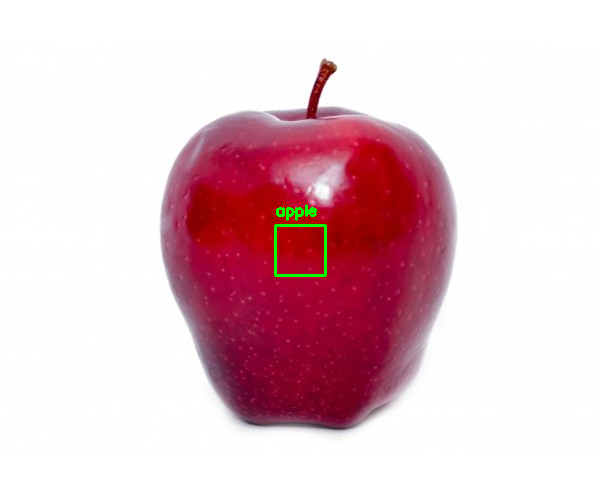

In [15]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow # Import the Colab-compatible imshow

def preprocess_image(image_path):
    """Loads, resizes, and normalizes the image."""
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    return img_resized, img  # Return both preprocessed and original images


def predict(image_path, model, label_encoder):
    """Predicts the class label for the given image."""
    img_array, original_img = preprocess_image(image_path)
    prediction = model.predict(img_array)  # Get softmax probabilities


    predicted_label_idx = np.argmax(prediction, axis=1)[0]  # Get the index of max probability
    predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]  # Decode label

    print(f"Predicted Label: {predicted_label}")
    print(f"Prediction Confidence: {np.max(prediction) * 100:.2f}%")


    height, width, _ = original_img.shape
    center_x, center_y = width // 2, height // 2
    box_size = 50  # Example size of bounding box
    xmin, ymin = max(center_x - box_size // 2, 0), max(center_y - box_size // 2, 0)
    xmax, ymax = min(center_x + box_size // 2, width), min(center_y + box_size // 2, height)

    detected_boxes = [[xmin, ymin, xmax, ymax]]  # One simulated box
    detected_labels = [predicted_label]  # Use predicted label

    return original_img, detected_boxes, detected_labels

def visualize_prediction(original_img, boxes, labels):
    """Draws bounding boxes and labels on the image."""
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(original_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Draw bounding box
        label_position = (xmin, ymin - 10)
        cv2.putText(original_img, labels[i], label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


    cv2_imshow(original_img) # Use cv2_imshow instead of cv2.imshow
    cv2.waitKey(0)
    cv2.destroyAllWindows()


image_path = r"/content/drive/MyDrive/7th Sem/DL/Object detection dataset/test/test/apple_80.jpg"

original_img, detected_boxes, detected_labels = predict(image_path, model, label_encoder)
visualize_prediction(original_img, detected_boxes, detected_labels)

# **Pre-Trained Model**

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.4947 - loss: 1.1358 - val_accuracy: 0.7849 - val_loss: 0.5957
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 0.7896 - loss: 0.5122 - val_accuracy: 0.8172 - val_loss: 0.3771
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - accuracy: 0.8619 - loss: 0.3676 - val_accuracy: 0.8710 - val_loss: 0.3001
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step - accuracy: 0.8948 - loss: 0.2864 - val_accuracy: 0.8817 - val_loss: 0.2952
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 462ms/step - accuracy: 0.8571 - loss: 0.2985 - val_accuracy: 0.8925 - val_loss: 0.2509
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.8929 - loss: 0.2774 - val_accuracy: 0.8925 - val_loss: 0.2212
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 391ms/step - accuracy: 0.9274 - loss: 0.2103 - val_accuracy: 0.9140 - val_loss: 0.2188
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 485ms/step - accuracy: 0.9075 - loss: 0.2168 - val_accuracy: 0.91

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Label: orange
Prediction Confidence: 99.04%


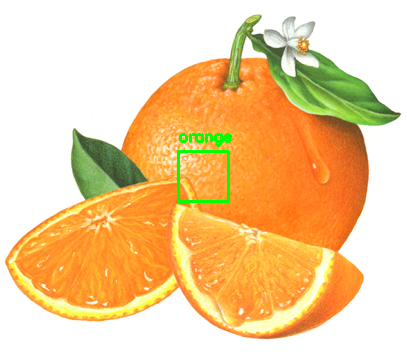

In [19]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def preprocess_image(image_path):
    """Loads, resizes, and normalizes the image."""
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224)) / 255.0  # Resize and normalize
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    return img_resized, img  # Return both preprocessed and original images


def predict(image_path, model, label_encoder):
    """Predicts the class label for the given image."""
    img_array, original_img = preprocess_image(image_path)
    prediction = model.predict(img_array)  # Get softmax probabilities


    predicted_label_idx = np.argmax(prediction, axis=1)[0]  # Get the index of max probability
    predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]  # Decode label

    print(f"Predicted Label: {predicted_label}")
    print(f"Prediction Confidence: {np.max(prediction) * 100:.2f}%")


    height, width, _ = original_img.shape
    center_x, center_y = width // 2, height // 2
    box_size = 50  # Example size of bounding box
    xmin, ymin = max(center_x - box_size // 2, 0), max(center_y - box_size // 2, 0)
    xmax, ymax = min(center_x + box_size // 2, width), min(center_y + box_size // 2, height)

    detected_boxes = [[xmin, ymin, xmax, ymax]]  # One simulated box
    detected_labels = [predicted_label]  # Use predicted label


    return original_img, detected_boxes, detected_labels


def visualize_prediction(original_img, boxes, labels):
    """Draws bounding boxes and labels on the image."""
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(original_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Draw bounding box
        label_position = (xmin, ymin - 10)
        cv2.putText(original_img, labels[i], label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


    cv2_imshow(original_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Example usage:
image_path = r"/content/drive/MyDrive/7th Sem/DL/Object detection dataset/test/test/orange_94.jpg"  # Replace with your image path

original_img, detected_boxes, detected_labels = predict(image_path, model, label_encoder)
visualize_prediction(original_img, detected_boxes, detected_labels)